In [1]:
%pip install transformers
%pip install accelerate
%pip install bitsandbytes
%pip install pyDOE3
%pip install datasets
%pip install torch
%pip install jinja2
%pip install torchmetrics
%pip install tqdm
%pip install jupyter
%pip install pretty-jupyter
%pip install researchpy
%pip install statsmodels
%pip install matplotlib
%pip install seaborn

In [2]:
import concurrent
import pandas as pd
import numpy as np
import scipy.stats as ss
import scipy as sp
import queue
import time
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import tqdm
import time
import os
import jinja2
import textwrap
import datasets
from threading import Thread
from tqdm.notebook import tqdm
from ipywidgets import IntProgress
from IPython.display import display
from typing import List, Tuple, Dict, Any, Generator, Callable
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import pandas as pd
from typing import List, Tuple
from pyDOE3 import *
import torch

2024-12-14 12:21:45.034722: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-14 12:21:45.051805: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-14 12:21:45.074026: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-14 12:21:45.080588: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-14 12:21:45.097447: I tensorflow/core/platform/cpu_feature_guar

In [3]:
# Enable dynamic CUDA shared allocations and enforce error reporting for CUDA operations
os.environ["TORCH_USE_CUDA_DSA"] = "1"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
df = pd.read_csv("drive/MyDrive/openrewriteeval_aaai24.csv")
df = df[:300]

In [6]:
example_template = jinja2.Template(
  textwrap.dedent(
    """Instruction: Rewrite the given text while keeping the same meaning. Do not write anything else!

    Given text: {{ review }}

    Rewritten text: """
  )
)

df["processed"] = df["source"].apply(lambda x: example_template.render(review=x))

dataset = datasets.Dataset.from_pandas(df)
dataset

Dataset({
    features: ['source', 'target', 'comment', 'task', 'processed'],
    num_rows: 300
})

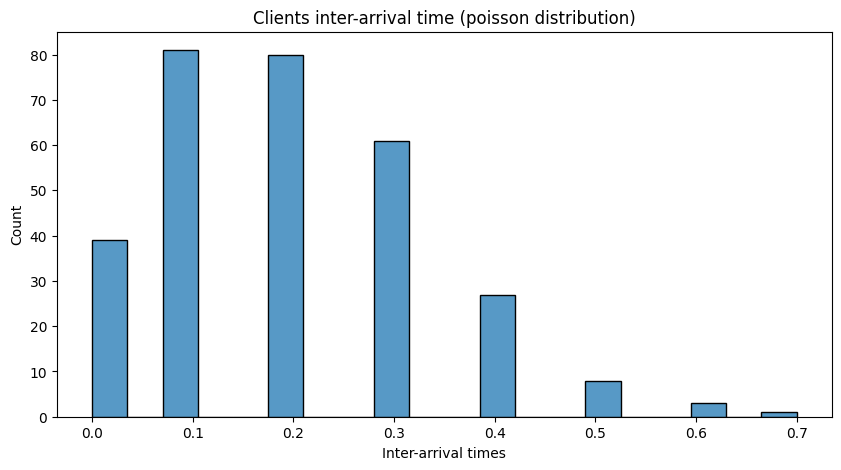

In [7]:
np.random.seed(5)
inter_arrival_time = np.random.poisson(2, df.shape[0]) / 10

plt.figure(figsize=(10, 5))

sns.histplot(
  inter_arrival_time,
  bins=20,
)
plt.title("Clients inter-arrival time (poisson distribution)")
plt.xlabel("Inter-arrival times")
plt.ylabel("Count")

plt.show()

In [8]:
class Service:
  def __init__(self, max_new_tokens: int):
    self.model: AutoModelForCausalLM = None
    self.tokenizer: AutoTokenizer = None
    self.max_new_tokens: int = max_new_tokens

  def load_model(
    self,
    model_name: str,
    quantization: int,
  ) -> Tuple[AutoTokenizer, AutoModelForCausalLM]:
    assert quantization in [4, 8, None], "Quantization must be either 4 or 8 bits"

    self.free()

    # Set up quantization configuration for the model
    quantization_config = None
    if quantization is not None:
        quantization_config = BitsAndBytesConfig(
            load_in_4bit=quantization == 4,
            load_in_8bit=quantization == 8
        )

    # Load the tokenizer (no need for quantization_config here)
    tokenizer = AutoTokenizer.from_pretrained(
        model_name,
        device_map="auto",
        torch_dtype="auto",
        padding_side="left",
    )

    # Ensure the tokenizer has a pad token, fallback to EOS if missing
    tokenizer.pad_token = tokenizer.pad_token or tokenizer.eos_token

    # Load the model with quantization and device mapping configurations
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        device_map="auto",
        torch_dtype="auto",
        quantization_config=quantization_config,
    )

    self.model = model
    self.tokenizer = tokenizer

  def __call__(self, batch: List[str]) -> List[str]:
    # Tokenize the batch input text
    tokenized_text = self.tokenizer.batch_encode_plus(
      list(batch),
      return_tensors="pt",
      padding=True
    )

    # Prepare input IDs and attention masks on the appropriate device
    input_ids = tokenized_text["input_ids"].to(self.model.device)
    attention_mask = tokenized_text["attention_mask"].to(self.model.device)

    # Generate model outputs for the input text
    output_ids = self.model.generate(
      input_ids=input_ids,
      attention_mask=attention_mask,
      max_new_tokens=self.max_new_tokens,      # Limit for text length
      temperature=1.0,                    # Lower for precise rewrites
      top_p=0.9,                          # Slightly tighter for coherence
      top_k=50                            # Focus on most probable tokens
    )

    # Decode the generated output text
    output_text = self.tokenizer.batch_decode(output_ids, skip_special_tokens=True)

    return output_text

  def free(self):
    del self.model
    del self.tokenizer

In [15]:
from collections import deque

class Server:
  def __init__(
    self,
    inter_arrival_time: np.ndarray,
    dataset: datasets.Dataset,
    batch_size_fn: Callable[[np.ndarray, np.ndarray, np.ndarray, np.ndarray], float],
    inter_arrival_time_buffer_size: int,
    n_workers: int = 1,
    work_fn: Callable[[float], None] = lambda x: time.sleep(x)
  ):
    assert inter_arrival_time.shape[0] == dataset.shape[0]
    self.inter_arrival_time = inter_arrival_time
    self.dataset = dataset
    self.max_count = inter_arrival_time.shape[0]
    self.progress_bar = IntProgress(min=0, max=self.max_count)
    self.job_queue = [queue.Queue() for _ in range(n_workers)]
    self.start_time = 0.
    self.running = False
    self.n_workers = n_workers
    self.work_fn = work_fn
    self.index = 0
    self.estimates_inter_arrival_times = deque(maxlen=inter_arrival_time_buffer_size)
    self.last_arrival_time = 0
    self.batch_size_fn = batch_size_fn
    self.buffer_times_job_time: List[Tuple[float, int, float]] = []

  def _get_waiting_time(self):
    if len(self.estimates_inter_arrival_times) <= 0:
      return 0

    waiting_times = np.array([i[2] for i in self.buffer_times_job_time])
    batch_sizes = np.array([i[1] for i in self.buffer_times_job_time])
    buffer_times = np.array([i[0] for i in self.buffer_times_job_time])
    return self.batch_size_fn(np.array(self.estimates_inter_arrival_times), waiting_times, batch_sizes, buffer_times)

  def _receive(self):
    """
    We simulate the inter arrival time by waiting for a delay specified in the dataframe
    """
    receive_time, task = next(self)
    time.sleep(receive_time)

    current_time = time.time()
    if self.last_arrival_time > 0:
      inter_arrival_time = current_time - self.last_arrival_time
      self.estimates_inter_arrival_times.append(inter_arrival_time)
    self.last_arrival_time = current_time

    return task

  def submitter(self):
    """
    Submitter function that submits job to the only worker queue between sleeps dictated
    by the input dataframe.
    We return the time each job was submitted to compute how long it remained in the queue
    afterwards.
    """
    queue = self.job_queue[0]
    result = np.zeros(self.max_count)
    submitter_index = 0
    for _ in range(self.max_count):
      task = self._receive()
      t = time.time() - self.start_time
      queue.put((t, task))
      result[submitter_index] = t
      submitter_index += 1
    print("Done submitting")
    self.running = False # Signal to worker to stop running after emptying the queue
    return (result,)

  def worker(self, idx=0):
    """
    A worker function to handle the jobs put in the queue. Each worker has its own queue.
    Processes tasks in batches of 4.
    """

    def _process_buffer(waiting_time: float, times: List[int], batch_sizes: List[int], buffer_ids: List[int], buffer: List[Tuple[int, str]]):
      """Helper function to process and mark tasks in the buffer."""
      start_time = time.time()
      if buffer:
          buffer_id = 0
          buffer_ids_values = list(filter(lambda x: x != None, buffer_ids))
          if len(buffer_ids_values) > 0:
            buffer_id = buffer_ids_values[-1] + 1

          output = self.work_fn(map(lambda x: x[1], map(lambda x: x[1], buffer)))  # Process batch
          print(output)
          self.progress_bar.value += len(buffer)  # Update progress bar
          for consumer_index, task in buffer:  # Mark all tasks as done
              receive_time = task[0]
              times[consumer_index] = time.time() - self.start_time
              batch_sizes[consumer_index] = len(buffer)
              self.buffer_times_job_time.append((waiting_time, len(buffer), times[consumer_index] - receive_time, buffer_id))
              buffer_ids[consumer_index] = buffer_id
              queue.task_done()
          buffer.clear()  # Clear the buffer
      end_time = time.time()
      return end_time - start_time

    queue = self.job_queue[idx]
    times = [None] * self.max_count
    batch_sizes = [None] * self.max_count
    buffer_ids = [None] * self.max_count
    consumer_index = 0
    task_buffer: List[Tuple[int, str]] = []  # Buffer to store tasks

    while self.running or not queue.empty():
      waiting_time = self._get_waiting_time()
      job_time = 0
      print(waiting_time)
      time.sleep(waiting_time)
      task_buffer = []
      start_consumer_index = consumer_index
      while not queue.empty():
        task_buffer.append([consumer_index, queue.get()])
        consumer_index += 1
      end_consumer_index = consumer_index
      batch_size = len(task_buffer)
      if len(task_buffer) > 0:
        print([i for i, _ in task_buffer])
        job_time = _process_buffer(waiting_time, times, batch_sizes, buffer_ids, task_buffer)

    print(f"done ({idx})")
    return times, batch_sizes, buffer_ids

  def run(self, save: str):
    """
    Method used to run the simulation. The submitter and every worker each get a separate thread.
    Note that due to python implementation the execution is not strictly concurrent, but we won't
    bother with that here.
    """
    self.running = True
    display(self.progress_bar)
    self.start_time = time.time()

    # Start two concurrent threads, notice that worker is started before submitter
    with concurrent.futures.ThreadPoolExecutor() as executor:
      future_workers = [executor.submit(self.worker, i) for i in range(self.n_workers)]
      future_submitter = executor.submit(self.submitter)
      submit_res = future_submitter.result()
      workers_res = [worker.result() for worker in future_workers]
      job_times = [item for worker_res in workers_res for item in worker_res[0]]
      batch_sizes = [item for worker_res in workers_res for item in worker_res[1]]
      buffer_ids = [item for worker_res in workers_res for item in worker_res[2]]

    print(len(job_times), len(batch_sizes), len(buffer_ids))
    print(job_times, batch_sizes, buffer_ids)

    res = pd.DataFrame(list(zip(*submit_res, job_times, batch_sizes, buffer_ids)))
    if save:
      res.to_csv(save,  index=False)
    return res

  def __iter__(self) -> Generator[Tuple[float, float], None, None]:
    """
    We use the iterator protocol to iterate over the dataframe
    """
    self.index = 0
    return self

  def __next__(self) -> Tuple[float, float, str]:
    if self.index >= self.max_count:
      raise StopIteration

    inter_arrival_time = self.inter_arrival_time[self.index]
    task = self.dataset[self.index]["processed"]  # Assuming ds has the processed field

    print(self.index, self.max_count)  # Debugging print to show progress
    self.index += 1  # Move to the next index
    return inter_arrival_time, task

In [12]:
service = Service(max_new_tokens=100)
service.load_model(model_name="meta-llama/Llama-3.2-1B", quantization=None)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [16]:
import math

def a(a, b, c, d):
  s = math.ceil(2 * b.std())
  t = 0
  if s > 0:
    t = int(np.random.randint(0, s))
  print(t)
  return t

server = Server(
    inter_arrival_time=inter_arrival_time,
    dataset=dataset,
    inter_arrival_time_buffer_size=100,
    batch_size_fn=a,
    n_workers=1,
    work_fn=lambda x: service(x),
)
server.run(save=None)

server.buffer_times_job_time

IntProgress(value=0, max=300)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Streaming output truncated to the last 5000 lines.
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


20 300
['Instruction: Rewrite the given text while keeping the same meaning. Do not write anything else!\n\n    Given text: Caught red handed by the pedestrian’s roadblock, the blinking crosswalk light only impeded my progress. It was too frosty for September, and I didn’t want to wait any longer. Then again seven-sixteen a.m. may have been too early to gauge the weather. The smell of autumn melded with the distant aroma of roasted meat and free trade coffee. Either of which served me no purpose. I clutched my 16oz thermos of my own brewed coffee— Starbucks, if you must know, because yes, I am a woman who needs a legitimate cup of corporation for breakfast. The commercialism offsets the home-created decadence of my succulent, delicious— I interrupted my own thoughts, amazed at my own drive. I darted diagonally through the street regardless. Past mornings have taught me that I won’t get caught. Hopefully, this morning wouldn’t be an exception.\n\n    Rewritten text:  I ran past a crossw

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


[20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]
47 300
48 300
49 300
50 300
51 300
52 300
53 300
54 300
55 300
56 300
57 300
58 300
59 300
60 300
61 300
62 300
63 300
64 300
65 300
66 300
["Instruction: Rewrite the given text while keeping the same meaning. Do not write anything else!\n\n    Given text: The Dickinson Family Education Conservatory is going to open later this year. That's going to be amazing. The garden doesn't have an indoor space that size, so it's going to be a plant-filled space and a place for education, meetings and events. That's a major milestone. The Botanic Garden has what I like to refer to as the best problem, which is that too many people want to come to it. Obviously, the garden has been built over the years for a smaller visitation audience than now comes. People love it more than initially envisioned 10 or 20 years ago when infrastructure was being installed. You have this excellent problem of askin

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


78 300
79 300
80 300
[46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
81 300
82 300
83 300
84 300
85 300
86 300
87 300
88 300
89 300
90 300
91 300
92 300
93 300
94 300
95 300
96 300
97 300
98 300
99 300
100 300
101 300
102 300
103 300
['Instruction: Rewrite the given text while keeping the same meaning. Do not write anything else!\n\n    Given text: Unfortunately, doctors sometimes fail to properly investigate a patient’s symptoms. This can occur for a variety of reasons. Sometimes, doctors make an incorrect assumption and then fail to properly test that assumption. This can occur when a patient’s symptoms seem to closely fit a commonly seen condition and that doctor simply accepts that diagnosis without further inquiry. Other misdiagnoses cases happen when a doctor neglects to order proper tests or fails to properly interpret the results of those tests. Another common cause of misdiagnosis occurs w

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


[80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108]
110 300
111 300
112 300
113 300
114 300
115 300
116 300
117 300
118 300
119 300
120 300
121 300
122 300
123 300
124 300
125 300
['Instruction: Rewrite the given text while keeping the same meaning. Do not write anything else!\n\n    Given text: In quite a few languages, finite verb forms agree in person and number with the subject. In Basque, a subset of verbs agree with up to three arguments: one in the absolutive case, one in ergative and one in dative. To distinguish the different values of person, number (and politeness and rarely even gender), there are special features for each of the three arguments. Their names contain the three-letter code of the case of the argument: absperson, absnumber, ergperson, ergnumber etc. The value range is identical to the base features. That is, absnumber, ergnumber and datnumber may get the same values as number.\n\n    Rew

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


[109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]
129 300
130 300
131 300
132 300
133 300
134 300
135 300
136 300
137 300
138 300
139 300
140 300
141 300
142 300
143 300
144 300
145 300
146 300
147 300
148 300
149 300
150 300
151 300
152 300
153 300
['Instruction: Rewrite the given text while keeping the same meaning. Do not write anything else!\n\n    Given text: Results Sample size was 178 (males 54.5 %, mean age = 39.29 years, mean illness duration = 13.29 years, mean total BPRS score = 32.11). Apathy had the highest mean score among the symptom clusters (6.54, SD 3.56), while blunted affect (1.87, SD 1.23) and emotional withdrawal (1.85, SD 1.26) had highest individual item mean scores. Patients on clozapine had significantly more symptoms of thought disturbance and animation compared to others, (P <0.05). There was no significant difference in symptoms between patients on typical and atypical antipsychotics. Those on higher doses of cl

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


159 300
[128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158]
160 300
161 300
162 300
163 300
164 300
165 300
166 300
167 300
168 300
169 300
170 300
171 300
172 300
173 300
174 300
175 300
176 300
177 300
178 300
179 300
180 300


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


['Instruction: Rewrite the given text while keeping the same meaning. Do not write anything else!\n\n    Given text: The success of genome-scale modeling can be attributed to high-quality, bottom-up reconstructions of metabolic, protein synthesis, and transcriptional regulatory networks on an organism-specific basis [1–4]. Such network reconstructions are biochemically, genetically, and genomically (BiGG) structured knowledge bases that can be used for discovery purposes (such as model-driven discovery of unidentified metabolic reactions, studies of evolutionary processes, and analysis of biological network properties), as well as practical applications (such as metabolic engineering, prediction of cellular phenotypes, and interspecies similarities and differences). Others have explored host/pathogen interactions, cocultures and microbial communities [10–13], ecology, and chemotaxis. Numerous recent developments have broadened the predictive scope of genome-scale models by incorporatin

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


['Instruction: Rewrite the given text while keeping the same meaning. Do not write anything else!\n\n    Given text: This morning I find myself meditating on the reality that as the Jesus Movement became the institutional church and gained both power and influence, it quickly abandoned its egalitarian roots and developed rigid systems of hierarchy and status that exist to this day. In personal practice and in my, admittedly small, circles of influence I am consciously trying to lead us back to the egalitarian spiritual roots of the Jesus Movement where everyone is of equal status in the body of Christ and where everyone is welcome at the table. We’ll let the ancient notion of “divine” rulers or those of higher or more noble “status” be simply a bit of nostalgia on our guest room wall.\n\n    Rewritten text:  This morning I meditate on the reality that the Jesus Movement as it became the institutional church and gained both power and influence is quickly abandoning its egalitarian roots

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


228 300
[202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227]
229 300
230 300
231 300
232 300
233 300
234 300
235 300
236 300
237 300
238 300
239 300
240 300
241 300
242 300
243 300
244 300
245 300
246 300
247 300
248 300
249 300
250 300
251 300
252 300
['Instruction: Rewrite the given text while keeping the same meaning. Do not write anything else!\n\n    Given text: 13.3 We and you agree that in the event of any dispute, the party wishing to address the dispute must contact the other party in writing, including by e-mail, and advise the other party of the dispute in reasonable detail as well as informing the other party of the remedy being sought. We may send you notices via the email address or physical address you provide to us, and all notices to us shall be sent to the following email address: inf@watchesofswitzerland.com and include the words “DISPUTE NOTICE” in the subject. The parties shall then make 

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


265 300
266 300
[228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265]
267 300
268 300
269 300
270 300
271 300
272 300
273 300
274 300
275 300
276 300
277 300
278 300
279 300
280 300
281 300
282 300
283 300
284 300
285 300
["Instruction: Rewrite the given text while keeping the same meaning. Do not write anything else!\n\n    Given text: Once I got over not having any metallic action in my fabric then I found out that it made much more sense to use Annex by Robert Allen for Dwell Studio. Besides I had in my mind that it would work best for my little boys room and the least expensive the better for a space like that (as a side note I'm still trying to get smashed cereal bar out of their fairly new rug). After seeing the fabric in person I made a deal and placed an order but then cancelled because at my local fabric retailer they still wanted a pretty pe

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


291 300
[266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290]
292 300
293 300
294 300
295 300
296 300
297 300
298 300
299 300
Done submitting
['Instruction: Rewrite the given text while keeping the same meaning. Do not write anything else!\n\n    Given text: 1955 At the end of May or beginning of June, Gagnon settles in the American metropolis, it is in throes of an exceptional cultural transformation in the Arts, the stimulating environment arouses his creative curiosity and he is carried into a period of intensive production. Between 1950 and 1960, New York is experiencing a period unprecedented artistic efflorescence. The values of abstract expressionism, then the symbol of “liberal” American culture, are being challenged by the innovative input of artists like Robert Rauchenberg and Jasper Johns (arts), John Cage (music and performance), Robert Frank (photography and film), Merce Cunningham (dance) and Jack Ker

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


[291, 292, 293, 294, 295, 296, 297, 298, 299]
['Instruction: Rewrite the given text while keeping the same meaning. Do not write anything else!\n\n    Given text: The Younger Dryas appeared similar to earlier events known as Heinrich events that were prominent in the Pleistocene (approximately 70,000 to 14,000 years ago) (1). Their cause is not altogether clear, but marine cores, primarily in the north-east Atlantic are festooned with layers of sand, pebbles and rock (lithic materials). These deposits arrived in this area by being carried within “large armadas” of ice that upon melting deposited their lodes on the ocean bottom. Rapid climate shifts have been linked to ice melt from sea ice and the large continental glaciers that surrounded the North Atlantic. Lower salinity meltwater is less dense than ocean water and tends to float as a freshwater cap over the marine waters, and this is perceived as associated with North Atlantic Ocean circulation disruption. The Younger Dryas is unde

[(0, 1, 3.385162353515625, 0),
 (0, 19, 7.085795640945435, 1),
 (0, 19, 6.985083818435669, 1),
 (0, 19, 6.984728574752808, 1),
 (0, 19, 6.783966541290283, 1),
 (0, 19, 6.583233118057251, 1),
 (0, 19, 6.38260817527771, 1),
 (0, 19, 6.181666851043701, 1),
 (0, 19, 6.081181049346924, 1),
 (0, 19, 5.980661392211914, 1),
 (0, 19, 5.679955005645752, 1),
 (0, 19, 5.47857928276062, 1),
 (0, 19, 5.477915287017822, 1),
 (0, 19, 5.377475261688232, 1),
 (0, 19, 5.076787948608398, 1),
 (0, 19, 4.776047229766846, 1),
 (0, 19, 4.3751678466796875, 1),
 (0, 19, 4.174514055252075, 1),
 (0, 19, 4.174170970916748, 1),
 (0, 19, 4.17393159866333, 1),
 (2, 26, 10.046325445175171, 2),
 (2, 26, 9.44550085067749, 2),
 (2, 26, 9.344597101211548, 2),
 (2, 26, 9.144009351730347, 2),
 (2, 26, 9.04349946975708, 2),
 (2, 26, 8.842835664749146, 2),
 (2, 26, 8.34151840209961, 2),
 (2, 26, 8.140863418579102, 2),
 (2, 26, 7.840156078338623, 2),
 (2, 26, 7.839725971221924, 2),
 (2, 26, 7.739368438720703, 2),
 (2, 26, 7.43

[(2, 26, 10.046325445175171, 2),
 (2, 26, 9.44550085067749, 2),
 (2, 26, 9.344597101211548, 2),
 (2, 26, 9.144009351730347, 2),
 (2, 26, 9.04349946975708, 2),
 (2, 26, 8.842835664749146, 2),
 (2, 26, 8.34151840209961, 2),
 (2, 26, 8.140863418579102, 2),
 (2, 26, 7.840156078338623, 2),
 (2, 26, 7.839725971221924, 2),
 (2, 26, 7.739368438720703, 2),
 (2, 26, 7.43867301940918, 2),
 (2, 26, 7.3380653858184814, 2),
 (2, 26, 6.9375035762786865, 2),
 (2, 26, 6.836877107620239, 2),
 (2, 26, 6.6362340450286865, 2),
 (2, 26, 6.235354661941528, 2),
 (2, 26, 6.234638690948486, 2),
 (2, 26, 5.633746385574341, 2),
 (2, 26, 5.232862710952759, 2),
 (2, 26, 5.132259130477905, 2),
 (2, 26, 4.931624889373779, 2),
 (2, 26, 4.730792045593262, 2),
 (2, 26, 4.730334758758545, 2),
 (2, 26, 4.629955053329468, 2),
 (2, 26, 4.429212331771851, 2),
 (3, 34, 11.391690015792847, 3),
 (3, 34, 10.99088191986084, 3),
 (3, 34, 10.890315771102905, 3),
 (3, 34, 10.58962869644165, 3),
 (3, 34, 10.58922529220581, 3),
 (3, 3

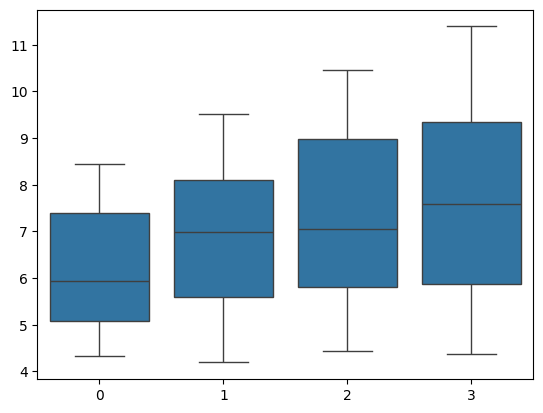

In [21]:
a = list(filter(lambda x: x[3] > 1, server.buffer_times_job_time ))
x = [i[0] for i in a]
y = [i[2] for i in a]
sns.boxplot(x=x, y=y)
a

In [23]:
pd.DataFrame(server.buffer_times_job_time).to_csv("random_times.csv")

In [ ]:
for percentile in np.arange(1, 5+1, 1, dtype=float):
  def a(iat):
    p = percentile*np.percentile(iat, 0.5 * 100)
    print(p)
    return p
  server = Server(
      inter_arrival_time=inter_arrival_time,
      dataset=dataset,
      inter_arrival_time_buffer_size=100,
      batch_size_fn=a,
      n_workers=1,
      work_fn=lambda x: service(x),
  )
  server.run(save=f"output_batch_size_times_{percentile}.csv")

In [ ]:
d = np.array(server.estimates_inter_arrival_times)

sns.histplot(d, bins=20)

percentile = 0.5
threshold_value = np.percentile(inter_arrival_time, percentile * 100)
plt.axvline(x=threshold_value, color='red', linestyle='--', label=f'Threshold ${percentile:.2f}')

plt.show()

In [ ]:
from collections import deque

class ServerFixedBatchSize:
  def __init__(
    self,
    inter_arrival_time: np.ndarray,
    dataset: datasets.Dataset,
    batch_size: int,
    n_workers: int = 1,
    work_fn: Callable[[float], None] = lambda x: time.sleep(x)
  ):
    assert inter_arrival_time.shape[0] == dataset.shape[0]
    self.inter_arrival_time = inter_arrival_time
    self.dataset = dataset
    self.max_count = inter_arrival_time.shape[0]
    self.progress_bar = IntProgress(min=0, max=self.max_count)
    self.job_queue = [queue.Queue() for _ in range(n_workers)]
    self.start_time = 0.
    self.running = False
    self.n_workers = n_workers
    self.work_fn = work_fn
    self.index = 0
    self.batch_size = batch_size

  def _receive(self):
    """
    We simulate the inter arrival time by waiting for a delay specified in the dataframe
    """
    receive_time, task = next(self)
    time.sleep(receive_time)

    return task

  def submitter(self):
    """
    Submitter function that submits job to the only worker queue between sleeps dictated
    by the input dataframe.
    We return the time each job was submitted to compute how long it remained in the queue
    afterwards.
    """
    queue = self.job_queue[0]
    result = np.zeros(self.max_count)
    submitter_index = 0
    for _ in range(self.max_count):
      task = self._receive()
      queue.put(task)
      result[submitter_index] = time.time() - self.start_time
      submitter_index += 1
    print("Done submitting")
    self.running = False # Signal to worker to stop running after emptying the queue
    return (result,)

  def worker(self, idx=0):
    """
    A worker function to handle the jobs put in the queue. Each worker has its own queue.
    Processes tasks in batches of 4.
    """

    def _process_buffer(times: List[int], batch_sizes: List[int], buffer_ids: List[int], buffer: List[Tuple[int, str]]):
      """Helper function to process and mark tasks in the buffer."""
      if buffer:
          buffer_id = 0
          buffer_ids_values = list(filter(lambda x: x != None, buffer_ids))
          if len(buffer_ids_values) > 0:
            buffer_id = buffer_ids_values[-1] + 1

          output = self.work_fn(map(lambda x: x[1], buffer))  # Process batch
          print(output)
          self.progress_bar.value += len(buffer)  # Update progress bar
          for consumer_index, task in buffer:  # Mark all tasks as done
              times[consumer_index] = time.time() - self.start_time
              batch_sizes[consumer_index] = len(buffer)
              buffer_ids[consumer_index] = buffer_id
              queue.task_done()
          buffer.clear()  # Clear the buffer

    queue = self.job_queue[idx]
    times = [None] * self.max_count
    batch_sizes = [None] * self.max_count
    buffer_ids = [None] * self.max_count
    consumer_index = 0
    task_buffer: List[Tuple[int, str]] = []  # Buffer to store tasks

    while self.running or not queue.empty():
        task_buffer.append([consumer_index, queue.get()])
        consumer_index += 1

        if len(task_buffer) >= self.batch_size:
          _process_buffer(times, batch_sizes, buffer_ids, task_buffer)

    _process_buffer(times, batch_sizes, buffer_ids, task_buffer)

    print(f"done ({idx})")
    return times, batch_sizes, buffer_ids

  def run(self, save: str):
    """
    Method used to run the simulation. The submitter and every worker each get a separate thread.
    Note that due to python implementation the execution is not strictly concurrent, but we won't
    bother with that here.
    """
    self.running = True
    display(self.progress_bar)
    self.start_time = time.time()

    # Start two concurrent threads, notice that worker is started before submitter
    with concurrent.futures.ThreadPoolExecutor() as executor:
      future_workers = [executor.submit(self.worker, i) for i in range(self.n_workers)]
      future_submitter = executor.submit(self.submitter)
      submit_res = future_submitter.result()
      workers_res = [worker.result() for worker in future_workers]
      job_times = [item for worker_res in workers_res for item in worker_res[0]]
      batch_sizes = [item for worker_res in workers_res for item in worker_res[1]]
      buffer_ids = [item for worker_res in workers_res for item in worker_res[2]]

    print(len(job_times), len(batch_sizes), len(buffer_ids))
    print(job_times, batch_sizes, buffer_ids)

    res = pd.DataFrame(list(zip(*submit_res, job_times, batch_sizes, buffer_ids)))
    if save:
      res.to_csv(save,  index=False)
    return res

  def __iter__(self) -> Generator[Tuple[float, float], None, None]:
    """
    We use the iterator protocol to iterate over the dataframe
    """
    self.index = 0
    return self

  def __next__(self) -> Tuple[float, float, str]:
    if self.index >= self.max_count:
      raise StopIteration

    inter_arrival_time = self.inter_arrival_time[self.index]
    task = self.dataset[self.index]["processed"]  # Assuming ds has the processed field

    print(self.index, self.max_count)  # Debugging print to show progress
    self.index += 1  # Move to the next index
    return inter_arrival_time, task

In [ ]:
batch_size = 20
server = ServerFixedBatchSize(
    inter_arrival_time=inter_arrival_time,
    dataset=dataset,
    batch_size=batch_size,
    n_workers=1,
    work_fn=lambda x: service(x),
)
server.run(save=f"output_batch_size_{batch_size}.csv")